In [1]:
import torch
import torch.nn as nn
import torchaudio
from timit_utils import preprocess, Timit 
from torch.utils.data import DataLoader

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
dataset = Timit('timit') # small subset (from kaggle)
path, wav, transcript, _, target = dataset[0]

/home/annareisz/miniconda3/envs/dlsp/lib/python3.11/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


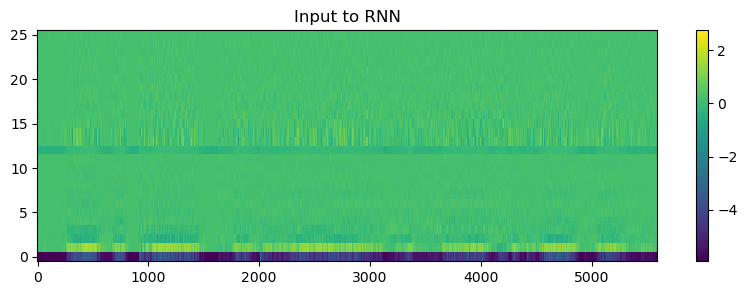

In [3]:
# plot wav as spectorgram
import matplotlib.pyplot as plt

features = preprocess(wav)

# add log energy
plt.figure(figsize=(10, 3))
plt.imshow(features.squeeze(0), aspect='auto', origin='lower', interpolation='none')
plt.title("Input to RNN")

#colorbar
cbar = plt.colorbar()
plt.show()

In [4]:
# dataloader for Timit dataset with unequal sequence lengths in a batch
from torch.nn.utils import rnn
PADDING_VALUE = 123456
def collate_fn(batch):
    x, y = [], []
    for i in range(len(batch)):
        _, wav, _, _, target = batch[i]
        features = preprocess(wav)
        x.append(features.squeeze(0).permute(1, 0))
        y.append(target)

    # sort by sequence length
    x_padded = rnn.pad_sequence(x, batch_first=True, padding_value=PADDING_VALUE)
    x_lens = torch.tensor([len(i) for i in x])
    x_lens, indices = x_lens.sort(descending=True)
    x_padded = x_padded[indices]
    x = rnn.pack_padded_sequence(x_padded, x_lens, batch_first=True, enforce_sorted=False)
    
    # sort by x lengths
    y_padded = rnn.pad_sequence(y, batch_first=True, padding_value=PADDING_VALUE)
    y_padded = y_padded[indices]
    y_lens = torch.tensor([len(i) for i in y])
    y_lens = y_lens[indices]
    y = rnn.pack_padded_sequence(y_padded, y_lens, batch_first=True, enforce_sorted=False)

    return x, y, y_lens, x_lens

        

# create dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

x, y, y_lens, x_lens = next(iter(dataloader))

In [5]:
class CTCModel(nn.Module):
    def __init__(self, num_classes=62):
        super(CTCModel, self).__init__()
        self.lstm = nn.LSTM(input_size=26, hidden_size=num_classes, num_layers=1, 
                            bidirectional=True)
        self.linear = nn.Linear(2*num_classes, num_classes) 
        self.softmax = nn.LogSoftmax(dim=2)
        self.num_classes = num_classes # num phonemes + 1 (for blank)
        
    def forward(self, x, x_lens):
        x, _ = self.lstm(x)
        # this insane exercises is needed for the linear layer to work
        # so pad twice
        # but the linear layer is neccessary when we have bididrectional lstm as output is 2*num_classes...
        x_split = torch.split(x.data, x_lens.tolist(), dim=0)
        x_padded = rnn.pad_sequence(x_split, batch_first=True, padding_value=PADDING_VALUE)
        out = self.linear(x_padded)
        out = self.softmax(out)
        return out
    

model = CTCModel()
emissions = model(x, x_lens)

In [6]:

# ctc loss
ctc_loss = nn.CTCLoss(blank=0)
loss = ctc_loss(emissions.permute(1, 0, 2), y.data, x_lens, y_lens) # I guess it doesn't like a mix of packed sequences and plain tensors, hence y.data

In [7]:
# trianing loop

from tqdm import tqdm
epochs=1000
model = CTCModel()
optimizer = torch.optim.SGD(model.parameters(), lr=10**(-4), momentum=0.9)
model.train()
ctc_loss = nn.CTCLoss()

num_steps = len(dataloader)*epochs
epoch = 1
with tqdm(range(num_steps)) as pbar:
    for step in pbar:
        print(step)
        x, y, y_lens, x_lens = next(iter(dataloader))
        optimizer.zero_grad()
        emissions = model(x, x_lens)
        loss = ctc_loss(emissions.permute(1, 0, 2), y.data, x_lens, y_lens)
        loss.backward()
        optimizer.step()

        # Report
        if step % 1 ==0 :
            loss = loss.detach().cpu()
            pbar.set_description(f"epoch={epoch}, step={step}, loss={loss:.1f}")

        if (step+1) % len(dataloader) == 0:
            epoch += 1

  0%|          | 0/5000 [00:00<?, ?it/s]